In [1]:
from IPython import display
from utils import Logger
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

def Fashion_mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])]
         #transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        )
    out_dir = './dataset'
    return datasets.FashionMNIST(root=out_dir, train=True, transform=compose, download=True)



# Load data
data = Fashion_mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)  #600*100
num_batches

In [ ]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            #nn.LeakyReLU(0.2),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            #nn.LeakyReLU(0.2),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


discriminator = DiscriminatorNet()




class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
generator = GeneratorNet()

In [6]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [7]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [8]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [11]:
#d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
#loss = nn.BCELoss()
loss=nn.MSELoss()
#optimizer = optim.Adam(generator.parameters(), lr=0.01)

In [12]:
def train_generator(optimizer, fake_data,real_data):
    N = fake_data.size(0)
    optimizer.zero_grad()    
    error = loss(fake_data, real_data)
    error.backward()    
    optimizer.step()
   
    return error

In [13]:
num_test_samples = 8
test_noise = noise(num_test_samples)

In [15]:
G_loss=[]
N=600
num_epochs=10
for epoch in range(num_epochs):
  
    LossG=0
    for n_batch, (real_batch,_) in enumerate(data_loader):

        
        # Train Generator
        fake_data = generator(noise(real_batch.size(0)))
        real_data = images_to_vectors(real_batch)
        g_error = train_generator(g_optimizer, fake_data,real_data)       
        
       
        LossG+=g_error.item()
    G_loss.append(LossG/N)
    print('epoch:',epoch,'G:',LossG/N)
print(G_loss) 

epoch: 0 G: 0.3555856298903624
epoch: 1 G: 0.3494771255552769
epoch: 2 G: 0.34916625703374543
epoch: 3 G: 0.34890608966350556
epoch: 4 G: 0.3487670202056567
epoch: 5 G: 0.348598361859719
epoch: 6 G: 0.34854034389058747
epoch: 7 G: 0.34841691121459006
epoch: 8 G: 0.348355991144975
epoch: 9 G: 0.34835621108611425
[0.3555856298903624, 0.3494771255552769, 0.34916625703374543, 0.34890608966350556, 0.3487670202056567, 0.348598361859719, 0.34854034389058747, 0.34841691121459006, 0.348355991144975, 0.34835621108611425]


Text(0, 0.5, 'Training Loss')

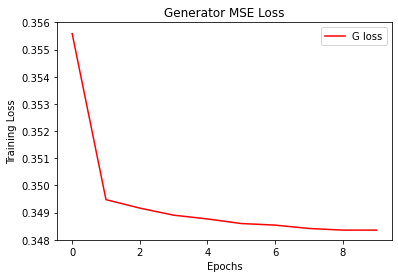

In [22]:
plt.plot(G_loss,'r')
plt.legend(['G loss'])
plt.title('Generator MSE Loss')
plt.ylim((0.348, 0.356))
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

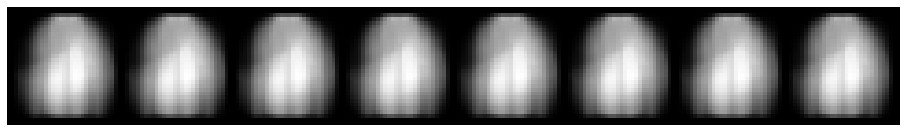

Epoch: [14/15], Batch Num: [500/600]
 Generator Loss: 0.3172
G: 0.0034819544782241185
[0.003482690143585205, 0.003482779575387637, 0.0034825503453612327, 0.003482229820887248, 0.0034822739630937577, 0.003481908044219017, 0.003482306050757567, 0.003482038728892803, 0.00348219759563605, 0.003481986017028491, 0.003481973795592785, 0.003482162552078565, 0.003481829186777274, 0.0034818283220132192, 0.0034819544782241185]


In [23]:
logger = Logger(model_name='VGAN', data_name='MNIST')

G_loss=[]
N=60000
num_epochs=15
for epoch in range(num_epochs):
  
    LossG=0
    for n_batch, (real_batch,_) in enumerate(data_loader):        
        # Train Generator
        fake_data = generator(noise(real_batch.size(0)))
        real_data = images_to_vectors(real_batch)
        # Train G
        g_error = train_generator(g_optimizer, fake_data,real_data)       
        logger.log(0, g_error, epoch, n_batch, num_batches)      
        LossG+=g_error.item()

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            
            print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
            print(' Generator Loss: {:.4f}'.format(g_error))
            
        
   
    G_loss.append(LossG/N)
    print('G:',LossG/N)
print(G_loss)  

In [ ]:
### WGAN